In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import sys
import h5py
from torch.optim import lr_scheduler

sys.path.append("../")
sys.path.append("../..")
from metric import *
from util import *
from model.pinn import PINNs

# 无粘Burgers方程: u_t + u*u_x = 0
# IC:u(x, 0) = sin(x)
# BC:u(0, t) = u(2π, t)

In [2]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:6'

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [3]:
# get data
# 几何区域：0<=x<=2*pi, 0<=t<=1
# 离散化：101*101网格
# res: 所有散点坐标
# b_left, b_right, b_upper, b_lower：边界点坐标
X_SIZE = 101
T_SIZE = 101

res, b_init, b_end, b_left, b_right = get_data([-1, 1], [0, 0.6],  X_SIZE, T_SIZE) 
res_test, _, _, _, _ = get_data([-1, 1], [0, 0.6],  X_SIZE, T_SIZE) 

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_init = torch.tensor(b_init, dtype=torch.float32, requires_grad=True).to(device)  # init
b_end = torch.tensor(b_end, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)  # right
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)  # left

# 分别提取散点的x t坐标 --> 列表
x_res, t_res = res[:,0:1], res[:,1:2]
x_init, t_init = b_init[:,0:1], b_init[:,1:2]
x_end, t_end = b_end[:,0:1], b_end[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]

# 有限体积采样边界点
DFVM_solver = DFVMsolver(1, device)
X_inL, X_inR = DFVM_solver.get_vol_data2(res)
X_inL  = X_inL.requires_grad_(True).to(device)  # 内部点的CV边界采样点
X_inR  = X_inR.requires_grad_(True).to(device)

print('x_inL: ', X_inL.shape)

print('res shape: ', res.shape, 'b_left shape: ', b_left.shape, 'b_right shape: ', b_right.shape, 'b_upper shape: ', b_init.shape, 'b_lower shape: ', b_end.shape)

x_inL:  torch.Size([10201, 2])
res shape:  torch.Size([10201, 2]) b_left shape:  torch.Size([101, 2]) b_right shape:  torch.Size([101, 2]) b_upper shape:  torch.Size([101, 2]) b_lower shape:  torch.Size([101, 2])


In [4]:
# Train PINNs -- MLP
model = PINNs(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
# optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
optim = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = lr_scheduler.ExponentialLR(optim, gamma=0.9, verbose=True)

print(model)
print(get_n_params(model))  # 总的参数量

/tmp/ipykernel_1071242/897607843.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527361


/home/pengguohang/anaconda3/envs/py3.8/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [5]:
# trian
loss_track = []
step_size = 5000
# 初始化lamda为可训练参数
lamda = torch.nn.Parameter(torch.tensor(1.0))

def jacobian(y, x, i, j):
    '''
    input: y[], x[]
    '''
    y = y[:,i]
    grad = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True)[0][:,j]  # y 相对于 x 的第 j 维的偏导数
    return grad.reshape(-1, 1)

def pde_burgers1D(x, model, nu):
    '''
    u_t + uu_x = 0

    input: x:[x, xL, xR] [内部点、CV左边界点、CV右边界点]
    '''
    x, t, xL, xR = x
    y = model(x, t)
    # print('in pde: ', y.shape, x.shape)
    dy_x = jacobian(y, x, i=0, j=0)
    dy_t = jacobian(y, t, i=0, j=0)
    yL = model(xL[:, 0:1], t)
    yR = model(xR[:, 0:1], t)
    dyR_x = jacobian(yR, xR, i=0, j=0)
    dyL_x = jacobian(yL, xL, i=0, j=0)
    res = (dy_t + y * dy_x)*0.0002 - nu*(dyR_x - dyL_x)  # 控制体积守恒性质
    
    return res.reshape(-1, 1)

pde = lambda x, model: pde_burgers1D(x, model, 0.001)
for i in tqdm(range(30000)):
    optim.zero_grad()

    pred_res = model(x_res, t_res)  # (n, 1)
    pred_init = model(x_init, t_init)  # init
    pred_left = model(x_left, t_left)  # right
    pred_right = model(x_right, t_right)  # left

    u = pred_res
    u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]  # (n, 1)
    u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

    loss_res_1 = torch.mean((u_t + u * u_x) ** 2)
    loss_res_2 = torch.mean(pde((x_res, t_res, X_inL,X_inR), model)**2)
    loss_res = loss_res_1 + lamda * loss_res_2
    loss_bc = torch.mean((pred_left - 1) ** 2 + (pred_right) ** 2)  # 边界：u(0, t) = 1, t>=0; u(1, t) = 0, t>=0
    loss_ic = torch.mean(torch.where(x_init <= 0, (pred_init-1) ** 2, pred_init ** 2))  # 初值：u(x, 0) = 1, x<=0; u(x, 0) = 0, x>0
    # print('loss: ', loss_res, loss_bc, loss_ic)

    loss = loss_res + loss_bc + loss_ic
    
    loss.backward()
    optim.step()  # 参数更新

    if (i+1) % step_size == 0:
        scheduler.step()

    with torch.no_grad():
        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])
    
    if i % 5000 == 0:
        print('Iter %d, res1: %.5e, res2: %.5e, Lossic: %.5e, Lossbc: %.5e, lamda: %.5e' % (i, loss_res_1.item(), loss_res_2.item(), loss_ic.item(), loss_bc.item(), lamda))

# Iter 0, res1: 9.58869e-03, res2: 3.83551e-10, Lossic: 6.57007e-01, Lossbc: 1.43382e+00
#  17%|█▋        | 5004/30000 [04:42<23:50, 17.47it/s]
# Iter 5000, res1: 3.73626e-03, res2: 9.79884e-11, Lossic: 2.00648e-02, Lossbc: 1.61417e-07
#  33%|███▎      | 10004/30000 [09:32<19:05, 17.45it/s]
# Iter 10000, res1: 3.51173e-03, res2: 1.10954e-10, Lossic: 1.95000e-02, Lossbc: 1.54758e-06
#  50%|█████     | 15004/30000 [14:23<14:20, 17.43it/s]
# Iter 15000, res1: 3.46422e-03, res2: 2.04416e-10, Lossic: 1.86014e-02, Lossbc: 4.39253e-05
#  67%|██████▋   | 20004/30000 [19:11<09:32, 17.46it/s]
# Iter 20000, res1: 3.30359e-03, res2: 3.07377e-10, Lossic: 1.83561e-02, Lossbc: 2.44319e-06
#  83%|████████▎ | 25004/30000 [25:58<04:47, 17.39it/s]
# Iter 25000, res1: 3.27592e-03, res2: 4.39718e-10, Lossic: 1.82634e-02, Lossbc: 5.75290e-06
# 100%|██████████| 30000/30000 [30:45<00:00, 16.25it/s]

  0%|          | 3/30000 [00:00<1:03:04,  7.93it/s]

Iter 0, res1: 9.58869e-03, res2: 3.83551e-10, Lossic: 6.57007e-01, Lossbc: 1.43382e+00, lamda: 1.00000e+00


 17%|█▋        | 5004/30000 [04:36<24:25, 17.06it/s]

Iter 5000, res1: 3.73626e-03, res2: 9.79884e-11, Lossic: 2.00648e-02, Lossbc: 1.61417e-07, lamda: 1.00000e+00


 33%|███▎      | 10004/30000 [09:26<19:50, 16.80it/s]

Iter 10000, res1: 3.51173e-03, res2: 1.10954e-10, Lossic: 1.95000e-02, Lossbc: 1.54758e-06, lamda: 1.00000e+00


 50%|█████     | 15004/30000 [14:19<14:30, 17.22it/s]

Iter 15000, res1: 3.46422e-03, res2: 2.04416e-10, Lossic: 1.86014e-02, Lossbc: 4.39253e-05, lamda: 1.00000e+00


 67%|██████▋   | 20004/30000 [19:10<09:41, 17.20it/s]

Iter 20000, res1: 3.30359e-03, res2: 3.07377e-10, Lossic: 1.83561e-02, Lossbc: 2.44319e-06, lamda: 1.00000e+00


 83%|████████▎ | 25004/30000 [24:02<04:50, 17.18it/s]

Iter 25000, res1: 3.27592e-03, res2: 4.39718e-10, Lossic: 1.82634e-02, Lossbc: 5.75290e-06, lamda: 1.00000e+00


100%|██████████| 30000/30000 [28:54<00:00, 17.30it/s]


In [6]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.003071, Loss_BC: 0.000001, Loss_IC: 0.018738
Train Loss: 0.021810


(101, 101)
relative L1 error: 0.063701
relative L2 error: 0.137785
MSE:  0.0109021
RMSE:  0.036581032
L2RE:  0.4520797
MaxE:  0.11138592


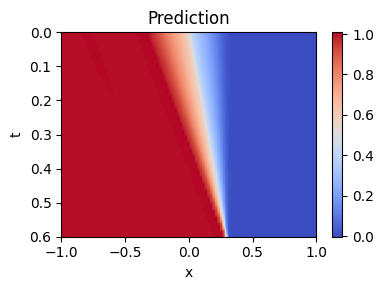

In [7]:
# Visualize PINNs 
X_SIZE = 101
T_SIZE = 101

res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

mat = scipy.io.loadmat('./burgers_move.mat')
u = mat['u'].reshape(X_SIZE, T_SIZE)

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()
pred = pred.reshape(X_SIZE, T_SIZE)

print(pred.shape)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))
print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

L2re = L2RE(torch.tensor(u), torch.tensor(pred)).mean()
MaxE = MaxError(torch.tensor(u), torch.tensor(pred)).mean()
Mse = MSE(torch.tensor(u), torch.tensor(pred)).mean()
Rmse = RMSE(torch.tensor(u), torch.tensor(pred)).mean()
print("MSE: ", Mse.detach().cpu().numpy())
print("RMSE: ", Rmse.detach().cpu().numpy())
print("L2RE: ", L2re.detach().cpu().numpy())
print("MaxE: ", MaxE.detach().cpu().numpy())


plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Prediction')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/dfvm_pred.png')
plt.show()

# relative L1 error: 0.063701
# relative L2 error: 0.137785
# MSE:  0.0109021
# RMSE:  0.036581032
# L2RE:  0.4520797
# MaxE:  0.11138592

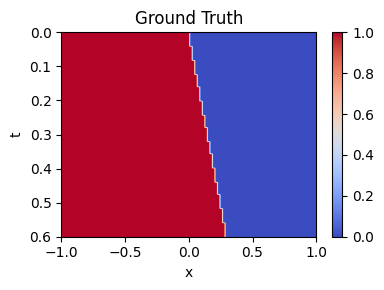

In [8]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Ground Truth')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_exact.png')
plt.show()

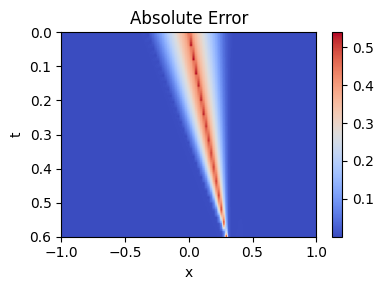

In [9]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(u - pred), extent=[-1,1,0.6,0], aspect='auto',  cmap='coolwarm')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_pinns_error.png')
plt.show()

(101, 101)


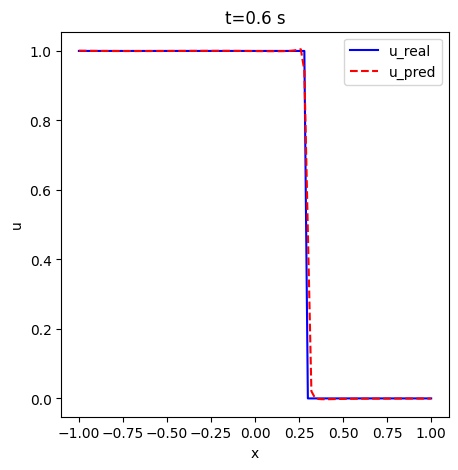

In [10]:
# 绘制t时刻的折线图
print(u.shape)
import matplotlib.pyplot as plt
import numpy as np

# 假设的时间序列数据
x = np.linspace(-1, 1, 101)
u_real = u[-1, :]  # 实际值，例如使用正弦波
u_pred = pred[-1, :]  # 预测值，添加一些噪声

plt.figure(figsize=(5, 5))
plt.plot(x, u_real, label='u_real', color='blue')  # 实际值曲线
plt.plot(x, u_pred, label='u_pred', color='red', linestyle='--')  # 预测值曲线

plt.title('t=0.6 s')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid(False)
plt.savefig('./image/burgers_pinns_0.6.png')
plt.show()
